In [1]:
import numpy
from matplotlib import pyplot
import matplotlib
import os
import scipy.optimize

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
basedir = "markov_data"

In [3]:
data = {}

for file in sorted(os.listdir(basedir)):
    if file.endswith(".npz"):
        arr = numpy.load(os.path.join(basedir, file))
        L = arr["L"][()]
        if L not in data:
            data[L] = []
        data[L].append({key: arr[key] for key in arr._files})

In [4]:
L = 32
ell = 16

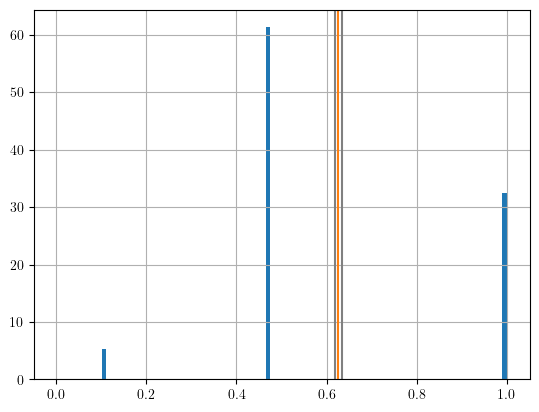

In [5]:
tp = data[L][0]["all_transition_probs"]

pyplot.hist(tp[:,ell*ell,0], bins=numpy.linspace(0,1,100), density=True)

ylims = pyplot.ylim()

xmean = tp[:,ell*ell,0].mean()
xmeanstd = tp[:,ell*ell,0].std() / numpy.sqrt(tp.shape[0])
pyplot.plot([xmean, xmean], [-1e6,1e6])
pyplot.plot([xmean-xmeanstd, xmean-xmeanstd], [-1e6,1e6], c='gray')
pyplot.plot([xmean+xmeanstd, xmean+xmeanstd], [-1e6,1e6], c='gray')
pyplot.ylim(ylims)
pyplot.grid()
pyplot.show()

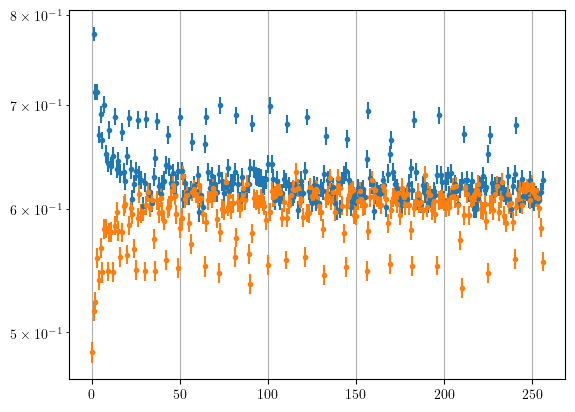

In [6]:
ks = []
pups = []
pupstds = []
pdowns = []
pdownstds = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    if "all_transition_probs" in d:
        k = d["k"][()]
        tp = d["all_transition_probs"]
        means = tp.mean(axis=0)
        stderrs = tp.std(axis=0) / numpy.sqrt(tp.shape[0])
        pyplot.errorbar(numpy.arange(means.shape[0]), means[:,0], yerr=stderrs[:,0], label=f"{k:.3f}", fmt='.')
        pyplot.errorbar(numpy.arange(means.shape[0]), means[:,1], yerr=stderrs[:,1], label=f"{k:.3f}", fmt='.')
        break
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

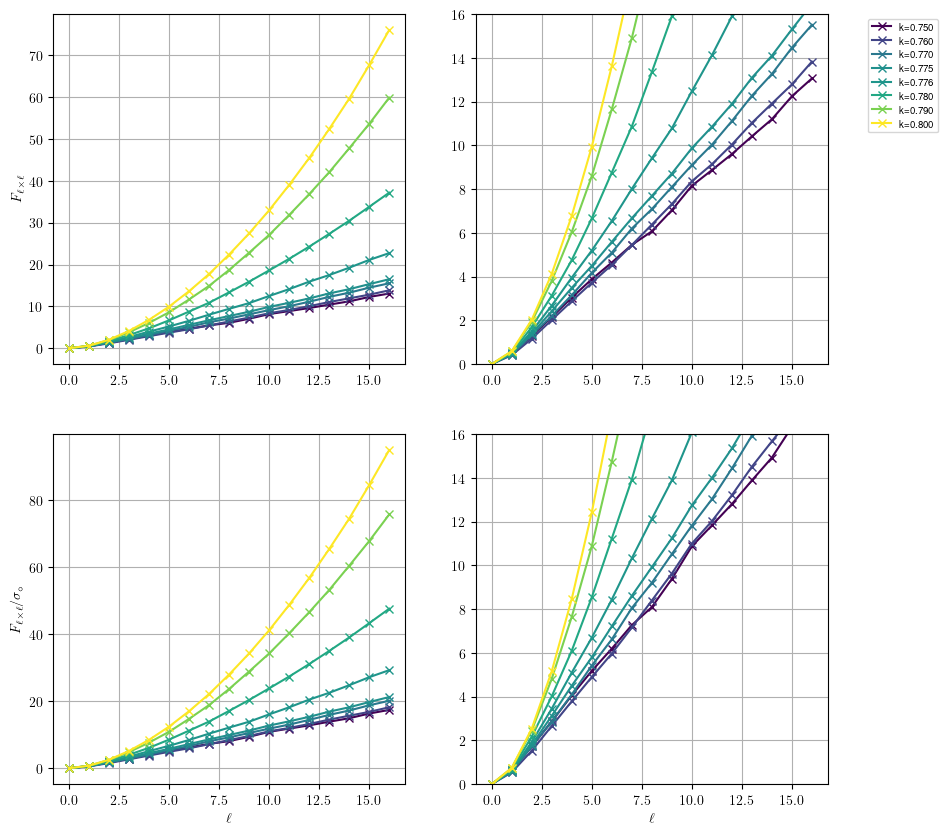

In [7]:
kmin = min(d["k"][()] for d in data[L])
kmax = max(d["k"][()] for d in data[L])
norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, axs = pyplot.subplots(2,2, figsize=(10,10))

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot([d["free_energy"][i*i] for i in range(ell+1)], "x-", label=f"k={k:.2f}", c=cmap(k))
axs[0,0].grid()
axs[0,0].set_ylabel(r"$F_{\ell \times \ell}$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot([d["free_energy"][i*i] / k for i in range(ell+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,0].grid()
axs[1,0].set_xlabel(r"$\ell$")
axs[1,0].set_ylabel(r"$F_{\ell \times \ell}/\sigma_\circ$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot([d["free_energy"][i*i] for i in range(ell+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[0,1].grid()
axs[0,1].set_ylim([0,16])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot([d["free_energy"][i*i] / k for i in range(ell+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,1].grid()
axs[1,1].set_ylim([0,16])
axs[1,1].set_xlabel(r"$\ell$")

axs[0,1].legend(fontsize=7, bbox_to_anchor=(1.1,1.0))

# pyplot.savefig("free_energy_flows.png")
pyplot.show()

In [8]:
all_dat = []

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = [d["free_energy"][i*i] for i in range(ell + 1)]
    gradlf = numpy.gradient(lf, edge_order=2)
    grad2lf = numpy.gradient(gradlf, edge_order=2)
    all_dat.append((k,lf, gradlf, grad2lf))

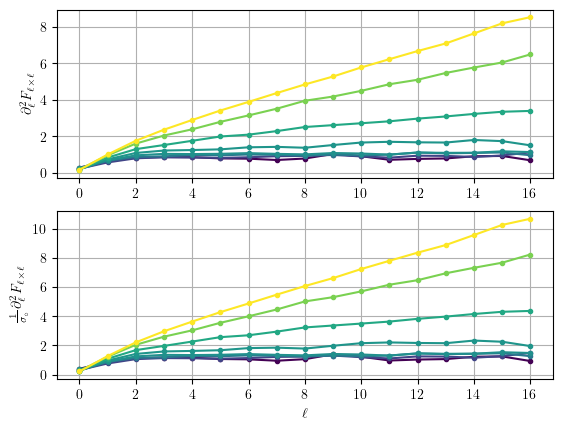

In [9]:
fig, axs = pyplot.subplots(2)

for (k, _, gradlf, _) in all_dat:
    axs[0].plot(gradlf, '.-', c=cmap(k))
axs[0].grid()
# axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, gradlf, _) in all_dat:
    axs[1].plot(gradlf/k, '.-', c=cmap(k))
axs[1].grid()
# axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.show()

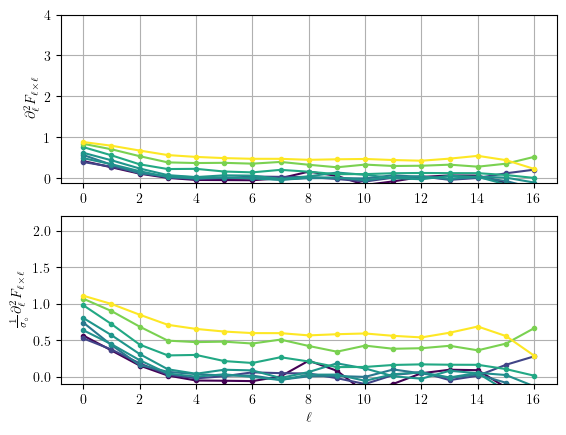

In [10]:
fig, axs = pyplot.subplots(2)

for (k, _, _, grad2lf) in all_dat:
    axs[0].plot(grad2lf, '.-', c=cmap(k))
axs[0].grid()
axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, _, grad2lf) in all_dat:
    axs[1].plot(grad2lf/k, '.-', c=cmap(k))
axs[1].grid()
axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.savefig("second_derive_across_ell.png")
pyplot.show()

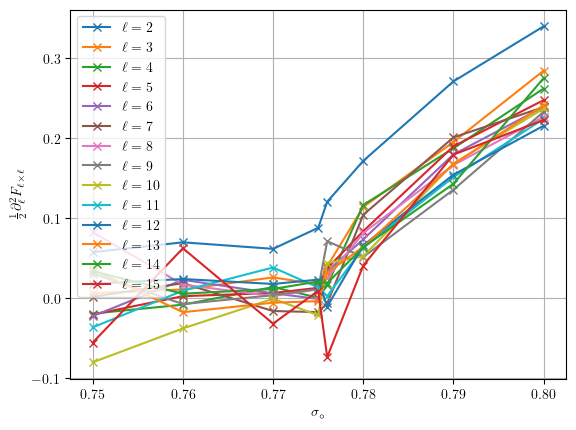

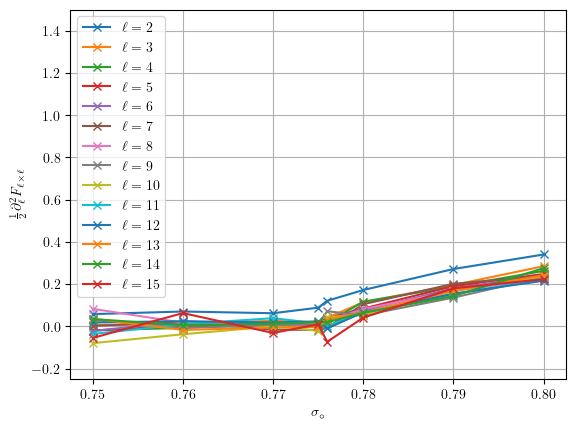

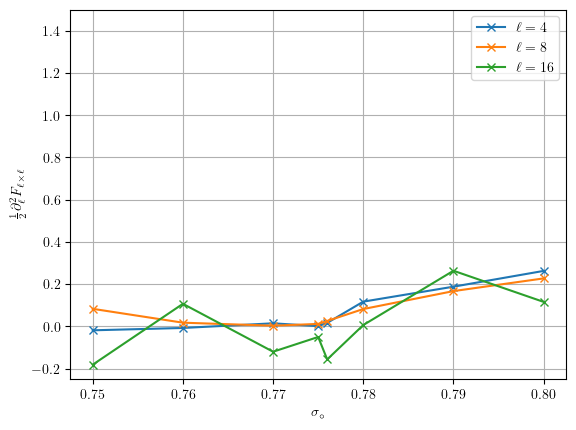

In [11]:
for i in range(2,ell):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.show()

for i in range(2,ell):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,1.5))
pyplot.show()


for i in [4, 8, 16]:
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,1.5))
pyplot.savefig("second_deriv.png")
pyplot.show()

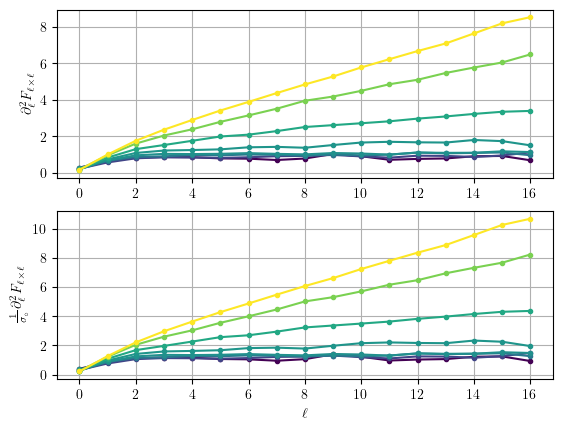

In [12]:
fig, axs = pyplot.subplots(2)

for (k, _, gradlf, _) in all_dat:
    axs[0].plot(gradlf, '.-', c=cmap(k))
axs[0].grid()
# axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, gradlf, _) in all_dat:
    axs[1].plot(gradlf/k, '.-', c=cmap(k))
axs[1].grid()
# axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.savefig("first_derive_across_ell.png")
pyplot.show()

In [13]:
fit_range_low, fit_range_high = (L//4, min(ell, (3*L)//4))

def lq(x, a, b):
    return b*x + a*x*x

ks = []
fits = []
fitsz = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    ls = numpy.arange(0,ell+1)
    f = numpy.array([d["free_energy"][i*i] for i in range(ell+1)])
    fit = numpy.polyfit(ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 2)
    ks.append(k)
    fits.append(fit)


    (a,b), pcov = scipy.optimize.curve_fit(lq, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 
                                           p0=[0.05,0.05])
    fitsz.append([a,b,0])

ks = numpy.array(ks)
fits = numpy.array(fits)
fitsz = numpy.array(fitsz)

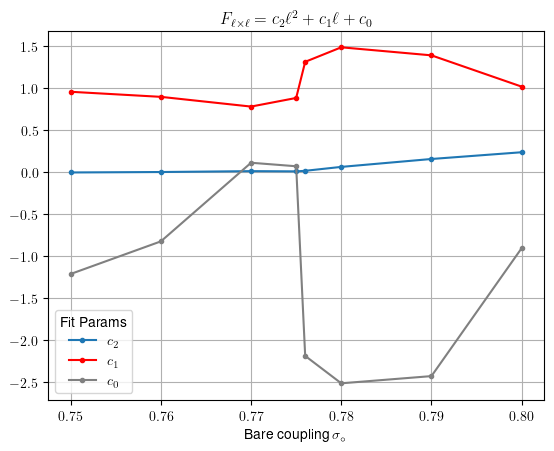

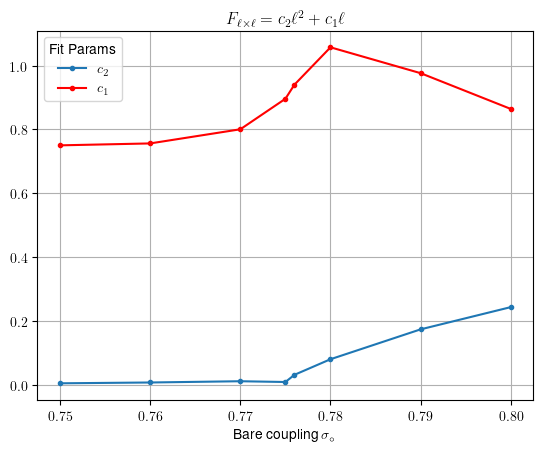

In [14]:
pyplot.plot(ks, fits[:,0], '.-', label="$c_2 $")
pyplot.plot(ks, fits[:,1], '.-', c='r', label="$ c_1 $")
pyplot.plot(ks, fits[:,2], '.-', c='gray', label="$ c_0 $")
pyplot.title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell + c_0$")
pyplot.grid()
pyplot.legend(title="Fit Params")
pyplot.xlabel(r"Bare coupling $\sigma_{\circ}$")
pyplot.show()

pyplot.plot(ks, fitsz[:,0], '.-', label="$c_2 $")
pyplot.plot(ks, fitsz[:,1], '.-', c='r', label="$ c_1 $")
pyplot.title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell$")
pyplot.grid()
pyplot.legend(title="Fit Params")
pyplot.xlabel(r"Bare coupling $\sigma_{\circ}$")
pyplot.show()